# Libraries

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
import json
from PIL import Image

# Boundary calculation

In [45]:
def bbox(path):
    # Load the image
    my_list = []
    image = cv2.imread(path)

    # Increase the size of the image
    height = 64
    if image.shape[0] < height:
        ratio = height / image.shape[0]
        width = int(image.shape[1] * ratio)
        image = cv2.resize(image, (width, height))

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply median blur to reduce noise
    blurred = cv2.medianBlur(gray, 3)

    # Apply adaptive thresholding to enhance the contrast
    th = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Perform morphological operations to fill gaps and smooth the image
    kernel = np.ones((3, 3), np.uint8)
    th = cv2.erode(th, kernel, iterations=1)
    th = cv2.GaussianBlur(th, (5, 5), 3)
    th = cv2.erode(th, kernel, iterations=2)

    # Apply a static threshold
    ret, th = cv2.threshold(th, 4, 255, cv2.THRESH_BINARY)

    # Calculate the total number of pixels in the image
    total_pixels = image.shape[0] * image.shape[1]

    # Set the minimum and maximum area based on a percentage of the total number of pixels
    min_area_percent = 0.00065  # 0.1%
    max_area_percent = 0.3   # 5%
    min_area = int(total_pixels * min_area_percent)
    max_area = int(total_pixels * max_area_percent)

    # Find connected components and filter based on area
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area < min_area or area > max_area:
            th[labels == i] = 0

    th = cv2.GaussianBlur(th, (5, 5), 3)
    th = cv2.erode(th, kernel, iterations=2)
    th = cv2.GaussianBlur(th, (5, 5), 3)
    ret, th = cv2.threshold(th, 4, 255, cv2.THRESH_BINARY)
    th = cv2.erode(th, kernel, iterations=1)
    th = cv2.GaussianBlur(th, (5, 5), 3)
    th = cv2.erode(th, kernel, iterations=1)
    ret, th = cv2.threshold(th, 60, 255, cv2.THRESH_BINARY)

    edges = cv2.Canny(th, 100, 100)
    edges = cv2.GaussianBlur(edges, (3,3), 1)
    edges = cv2.erode(edges, kernel, iterations=1)
    ret, edges = cv2.threshold(edges, 18, 255, cv2.THRESH_BINARY)

    # Find contours from edges
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a new blank image
    filled = np.zeros_like(edges)

    # Fill each contour with white
    cv2.fillPoly(filled, contours, 255)
    filled = cv2.erode(filled, kernel, iterations=1)

    # Calculate total number of pixels in the image
    total_pixels = image.shape[0] * image.shape[1]

    # Set min and max size of bounding boxes based on pixel density
    min_size = int(total_pixels * 0.0001) # 0.05% of total pixels
    max_size = int(total_pixels * 0.45) # 5% of total pixels

    # Set min and max aspect ratios of bounding boxes
    min_aspect_ratio = 0.1
    max_aspect_ratio = 5.5

    contours, hierarchy = cv2.findContours(filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find bounding boxes around each digit
    digit_bboxes = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        bbox_area = w * h
        aspect_ratio = float(w) / h
        touching_bounds = (x == 0 or y == 0 or x+w == image.shape[1] or y+h == image.shape[0])
        if bbox_area > min_size and bbox_area < max_size and aspect_ratio > min_aspect_ratio and aspect_ratio < max_aspect_ratio and not touching_bounds:
            digit_bboxes.append((x, y, x+w, y+h))
            image_id = path.split('/')
            my_dict = {'image_id': image_id[6] , 'x': x,'y':y,"width":w,"height":h}
            my_list.append(my_dict)

    # Draw bounding boxes on the original image
    image_with_boxes = image.copy()
    for bbox in digit_bboxes:
        cv2.rectangle(image_with_boxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
        
        
    return(my_list, image, digit_bboxes)


# Accuracy Calculation (IoU)

In [46]:
# Load the digitStruct.json file
def load_json(path):
    with open(path) as file:
        data = json.load(file)
    return data

# Calculate intersection over union (IOU)
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate intersection coordinates
    x_inter = max(x1, x2)
    y_inter = max(y1, y2)
    w_inter = min(x1 + w1, x2 + w2) - x_inter
    h_inter = min(y1 + h1, y2 + h2) - y_inter
    
    # Calculate intersection area
    area_inter = w_inter * h_inter
    
    # Calculate union area
    area_box1 = w1 * h1
    area_box2 = w2 * h2
    area_union = area_box1 + area_box2 - area_inter
    
    # Calculate IOU
    iou = area_inter / area_union
    
    return iou

# Load the bounding boxes into a Pandas dataframe
df = pd.DataFrame(columns=['image_id', 'x', 'y', 'width', 'height'])
for i in range(50):
    path = 'C:/Users/yshal/Downloads/Vision/train/' + str(i+1) + '.png'
    bbox_list = bbox(path)[0]
    for bbox_dict in bbox_list:
        bbox_dict['image_id'] = i+1
        df = df.append(bbox_dict, ignore_index=True)
df = df.sort_values(['image_id', 'x'])


# Load the digitStruct.json file
digit_struct = load_json('C:/Users/yshal/Downloads/Vision/train/digitStruct.json')

# Loop through the digitStruct.json file and calculate the IOU for each bounding box
total_boxes = 0
correct_boxes = 0
for i in range(50):
    img_path = 'C:/Users/yshal/Downloads/Vision/train/' + str(i+1) + '.png'
    img = Image.open(img_path)
    
    for box in digit_struct[i]['boxes']:
        # Get the bounding box coordinates from digitStruct.json
        left = box['left']
        top = box['top']
        width = box['width']
        height = box['height']
        label = int(box['label'])
        
        # Calculate the IOU between the bounding box from digitStruct.json and the bounding boxes from df
        iou_list = []
        for index, row in df[df['image_id']==i+1].iterrows():
            iou = calculate_iou([left, top, width, height], [row['x'], row['y'], row['width'], row['height']])
            iou_list.append(iou)
            
        if len(iou_list) > 0:
            max_iou = max(iou_list)
            if max_iou > 0.2:
                correct_boxes += 1
                
        total_boxes += 1

accuracy = correct_boxes / total_boxes
print('Accuracy: {:.2f}%'.format(accuracy * 100))

C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users

C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users

C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users

C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\4226500790.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users

Accuracy: 70.91%


# Function to draw boundary boxes

In [25]:
def draw_bbox(image,digit_bboxes):
    # Draw bounding boxes on the original image
    
    for bbox in digit_bboxes:
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
    # Display the image with bounding boxes
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

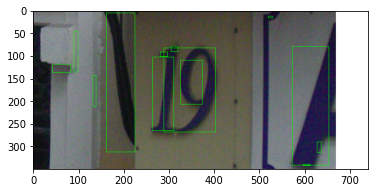

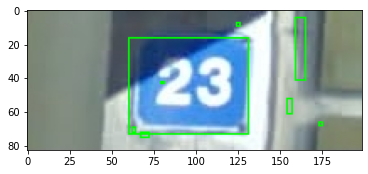

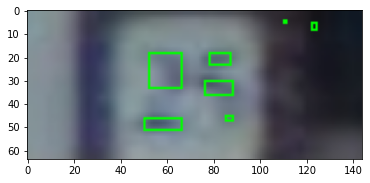

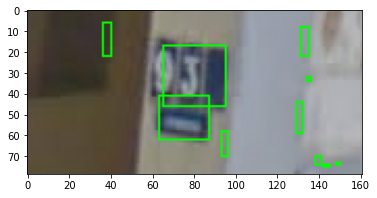

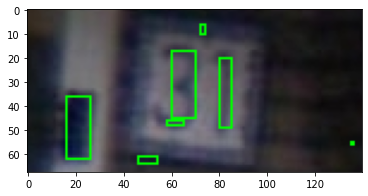

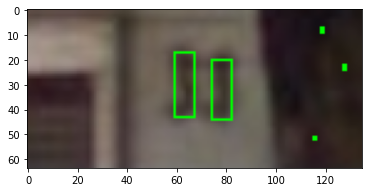

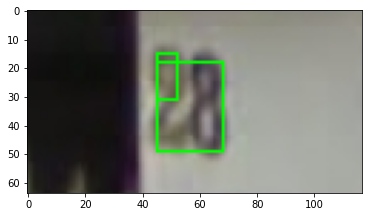

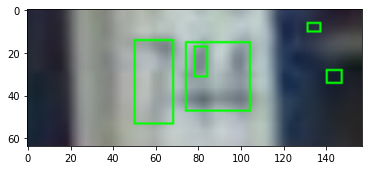

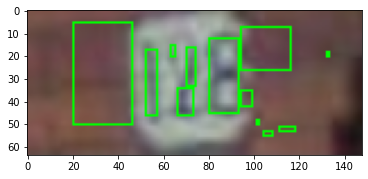

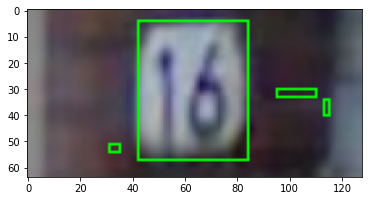

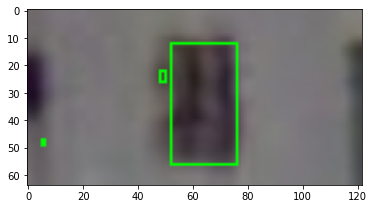

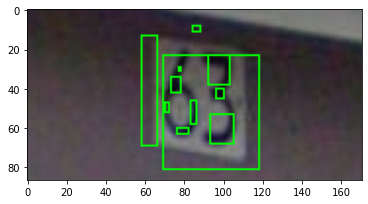

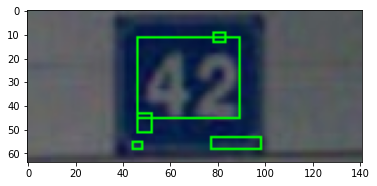

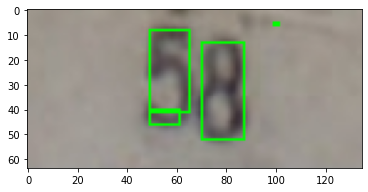

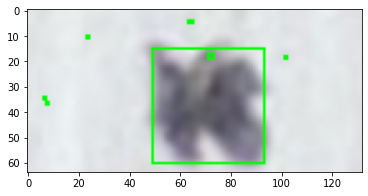

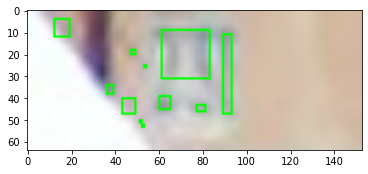

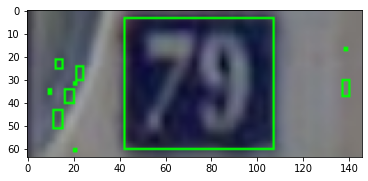

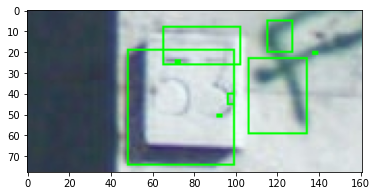

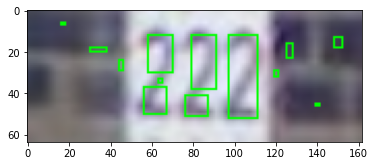

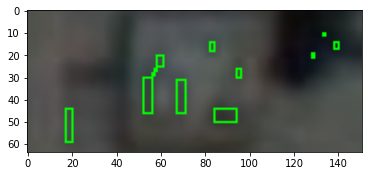

In [48]:
for i in range(20):

    image=bbox('C:/Users/yshal/Downloads/Vision/train/'+str(i+1)+'.png')[1]
    digit_bboxes=bbox('C:/Users/yshal/Downloads/Vision/train/'+str(i+1)+'.png')[2]
    draw_bbox(image,digit_bboxes)


# Less accuracy with less BBoxes

In [49]:
def bbox2(path):
    # Load the image
    my_list = []
    image = cv2.imread(path)

    # Increase the size of the image
    height = 64
    if image.shape[0] < height:
        ratio = height / image.shape[0]
        width = int(image.shape[1] * ratio)
        image = cv2.resize(image, (width, height))

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply median blur to reduce noise
    blurred = cv2.medianBlur(gray, 3)

    # Apply adaptive thresholding to enhance the contrast
    th = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Perform morphological operations to fill gaps and smooth the image
    kernel = np.ones((3, 3), np.uint8)
    th = cv2.erode(th, kernel, iterations=1)
    th = cv2.GaussianBlur(th, (5, 5), 3)
    th = cv2.erode(th, kernel, iterations=2)

    # Apply a static threshold
    ret, th = cv2.threshold(th, 4, 255, cv2.THRESH_BINARY)

    # Calculate the total number of pixels in the image
    total_pixels = image.shape[0] * image.shape[1]

    # Set the minimum and maximum area based on a percentage of the total number of pixels
    min_area_percent = 0.001  # 0.1%
    max_area_percent = 0.2   # 5%
    min_area = int(total_pixels * min_area_percent)
    max_area = int(total_pixels * max_area_percent)

    # Find connected components and filter based on area
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area < min_area or area > max_area:
            th[labels == i] = 0

    th = cv2.GaussianBlur(th, (5, 5), 3)
    th = cv2.erode(th, kernel, iterations=2)
    th = cv2.GaussianBlur(th, (5, 5), 3)
    ret, th = cv2.threshold(th, 4, 255, cv2.THRESH_BINARY)
    th = cv2.erode(th, kernel, iterations=1)
    th = cv2.GaussianBlur(th, (5, 5), 1)
    th = cv2.erode(th, kernel, iterations=1)
    ret, th = cv2.threshold(th, 8, 255, cv2.THRESH_BINARY)

    edges = cv2.Canny(th, 100, 100)
    edges = cv2.GaussianBlur(edges, (3,3), 1)
    edges = cv2.erode(edges, kernel, iterations=1)
    ret, edges = cv2.threshold(edges, 18, 255, cv2.THRESH_BINARY)

    # Find contours from edges
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a new blank image
    filled = np.zeros_like(edges)

    # Fill each contour with white
    cv2.fillPoly(filled, contours, 255)
    filled = cv2.erode(filled, kernel, iterations=1)

    # Calculate total number of pixels in the image
    total_pixels = image.shape[0] * image.shape[1]

    # Set min and max size of bounding boxes based on pixel density
    min_size = int(total_pixels * 0.019) # 0.05% of total pixels
    max_size = int(total_pixels * 0.2) # 5% of total pixels

    # Set min and max aspect ratios of bounding boxes
    min_aspect_ratio = 0.1
    max_aspect_ratio = 1.0

    contours, hierarchy = cv2.findContours(filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find bounding boxes around each digit
    digit_bboxes = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        bbox_area = w * h
        aspect_ratio = float(w) / h
        touching_bounds = (x == 0 or y == 0 or x+w == image.shape[1] or y+h == image.shape[0])
        if bbox_area > min_size and bbox_area < max_size and aspect_ratio > min_aspect_ratio and aspect_ratio < max_aspect_ratio and not touching_bounds:
            digit_bboxes.append((x, y, x+w, y+h))
            image_id = path.split('/')
            my_dict = {'image_id': image_id[1] , 'x': x,'y':y,"width":w,"height":h}
            my_list.append(my_dict)

    # Draw bounding boxes on the original image
    image_with_boxes = image.copy()
    for bbox in digit_bboxes:
        cv2.rectangle(image_with_boxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
        
        
    return(my_list, image , digit_bboxes)

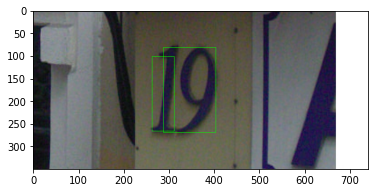

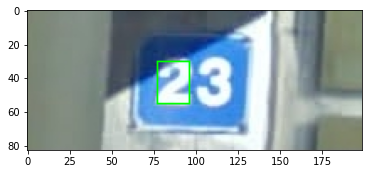

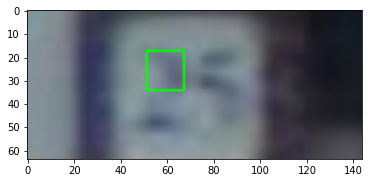

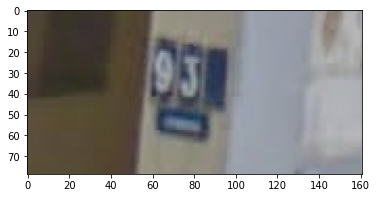

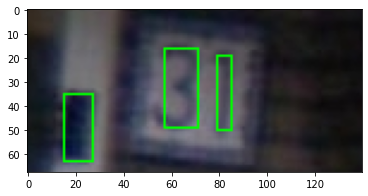

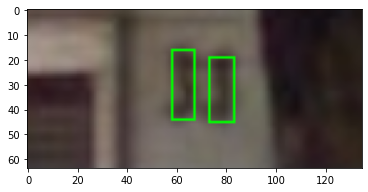

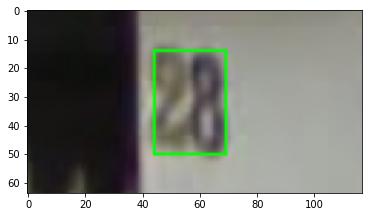

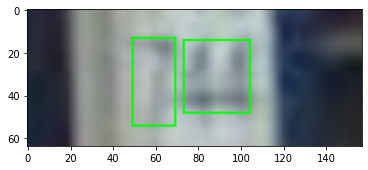

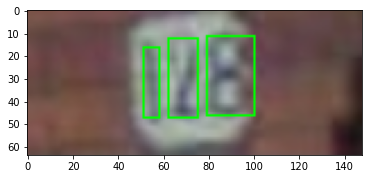

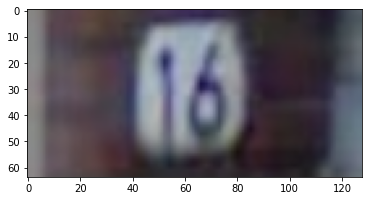

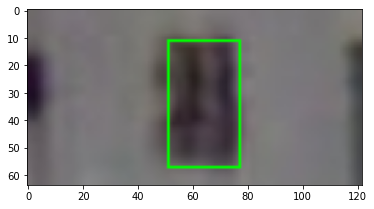

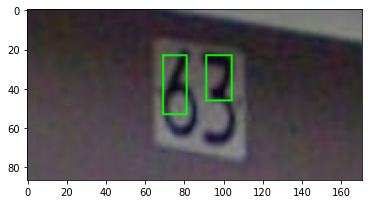

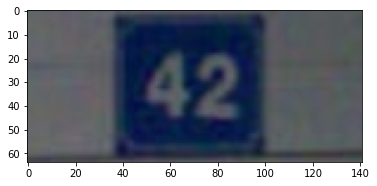

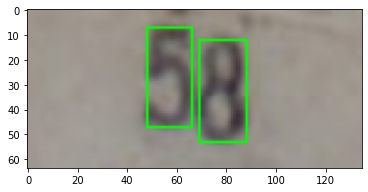

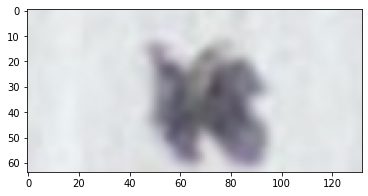

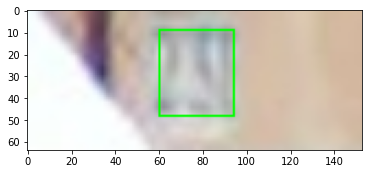

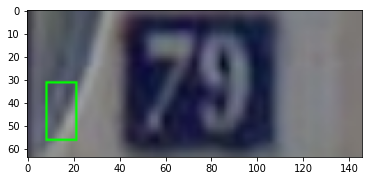

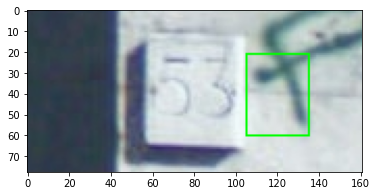

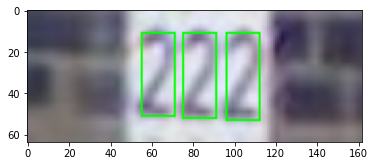

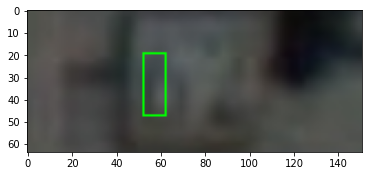

In [51]:
for i in range(20):

    image=bbox2('C:/Users/yshal/Downloads/Vision/train/'+str(i+1)+'.png')[1]
    digit_bboxes=bbox2('C:/Users/yshal/Downloads/Vision/train/'+str(i+1)+'.png')[2]
    draw_bbox(image,digit_bboxes)


In [52]:
# Load the bounding boxes into a Pandas dataframe
df = pd.DataFrame(columns=['image_id', 'x', 'y', 'width', 'height'])
for i in range(50):
    path = 'C:/Users/yshal/Downloads/Vision/train/' + str(i+1) + '.png'
    bbox_list = bbox2(path)[0]
    for bbox_dict in bbox_list:
        bbox_dict['image_id'] = i+1
        df = df.append(bbox_dict, ignore_index=True)
df = df.sort_values(['image_id', 'x'])


# Load the digitStruct.json file
digit_struct = load_json('C:/Users/yshal/Downloads/Vision/train/digitStruct.json')

# Loop through the digitStruct.json file and calculate the IOU for each bounding box
total_boxes = 0
correct_boxes = 0
for i in range(50):
    img_path = 'C:/Users/yshal/Downloads/Vision/train/' + str(i+1) + '.png'
    img = Image.open(img_path)
    
    for box in digit_struct[i]['boxes']:
        # Get the bounding box coordinates from digitStruct.json
        left = box['left']
        top = box['top']
        width = box['width']
        height = box['height']
        label = int(box['label'])
        
        # Calculate the IOU between the bounding box from digitStruct.json and the bounding boxes from df
        iou_list = []
        for index, row in df[df['image_id']==i+1].iterrows():
            iou = calculate_iou([left, top, width, height], [row['x'], row['y'], row['width'], row['height']])
            iou_list.append(iou)
            
        if len(iou_list) > 0:
            max_iou = max(iou_list)
            if max_iou > 0.2:
                correct_boxes += 1
                
        total_boxes += 1

accuracy = correct_boxes / total_boxes
print('Accuracy: {:.2f}%'.format(accuracy * 100))

C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\124566812.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\124566812.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\124566812.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\124566812.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\A

C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\124566812.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\124566812.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)
C:\Users\yshal\AppData\Local\Temp\ipykernel_20220\124566812.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bbox_dict, ignore_index=True)


Accuracy: 27.27%
